# Classification of quantum states with high dimensional entanglement 

## Circuits and computations
Version compatible with 1st and 2d pilot studies

In [2]:
import numpy as np
import copy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, execute, transpile, assemble
from qiskit.tools.visualization import *
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
import json
from scipy.signal import savgol_filter
import time
from qiskit.tools.monitor import job_monitor

In [3]:
from o_utils import ora # classifier utilities
from o_plot import opl # utilities for result plot
from c_utils import new_cut # circuit building utilities

In [4]:
def json_dic_loader(dic_name):
    f = open(data_directory+dic_name+'.json')
    return json.load(f)

In [5]:
#markdown for safety on demo
def json_dic_dumper(dic, dic_name):
    with open(data_directory+dic_name+'.json', 'w') as f:
        json.dump(dic,f)   

In [6]:
# common code for calling the classifier for ideal device and for real devices
def add_single_dic(target_data_list):
    start_time = time.time()                
           
    print("started",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name)
    
    # added for D,S,M choice. Mainstream : mixed set of 20 states
    first = 0
    last = nb_states
    if unique_char == "D":
        last = int(nb_states/2)
    elif unique_char == "S":
        first = int(nb_states/2)
    
    # get the classifier error curve in function of the number of shot and the "safe shot number" 
    error_curve, safe_rate, ernb = ora.provide_error_curve(PD_model=model_dic[model_name][first:last,:],
                                                   PD_test=PD_test[first:last,:],
                                                   trials=trials,
                                                   window=window,
                                                   epsilon=epsilon,
                                                   max_shots=max_shots,
                                                   pol=pol,
                                                   verbosality=verbosality)

    tail = savgol_filter(ernb, window, pol, axis=0)
    len_curve = len(error_curve)
    safe_shot_nb = len_curve - int((window-1)/2) # OK
    print('safe_shot_nb',safe_shot_nb, 'safe_rate',safe_rate, "nb trials:",trials)
    err_rates = tail[int((window-1)/2),:]/trials 
    err_rate_max = np.max(err_rates)
    err_rate_min = np.min(err_rates)
    r=4
    print("savgol interpolated error rate mean:", np.round(np.mean(err_rates),r),
          "min:", np.round(err_rate_min,r),
          "max:", np.round(err_rate_max,r), "for",
          [ien for ien, jen in enumerate(err_rates) if jen == err_rate_max])
    end_time = time.time()
    
    #save the data in a list of dictionaries :
    single_dic={"project":mitig_name,
                "id_gates":id_gates,
                "mitigation":mit_str,
                "model":model_name,
                "metric":o_metric, "device":project_device,                              
                "curve_length":len_curve, 
                "shots": safe_shot_nb,
                "shots_rate": safe_rate,                                                                                    
                "error_curve":error_curve,
                "trials":trials,"window":window,
                "epsilon":epsilon,"SG_pol": pol,                         
                "computation_time":end_time-start_time,
                "time_completed":time.strftime('%d/%m/%Y %H:%M:%S'),
                "trials":trials,
                "QV": QV_dic[project_device],
                "fidelity": fidelity_dic[project_device],
                "error_nb":ernb}
    target_data_list.append(single_dic)
    
    print("completed",time.strftime('%d/%m/%Y %H:%M:%S'),mitig_name,
          "mitigation",mit_str,o_metric,model_name,"\n")

## Set up the simulator and layout for 5 qubits

In [7]:
simulator = Aer.get_backend('qasm_simulator')

In [8]:
#specify the layout of the devices
used_qubits = 5
qubit_list = [0,1,2,3,4]

In [9]:
#short_version = False
#program_name="QAD" # 1st pilot project GHZ Psi+ / W Phi+
program_name="AL2" # 2d pilot project W Psi+ / Wbar Phi+
Flag_char = "DS" # this for a mix of two types of separable states
if len(Flag_char) >= 2:
    unique_char = "M"
else:
    unique_char = Flag_char

In [51]:
# These dictionaries for the devices used in the study
if program_name == "QAD":
    fidelity_dic = {'ibmq_athens': 0.925110, 'ibmq_valencia': 0.809101, 'ibmq_ourense': 0.802380,"ibmqx2": 0.627392, 
                    'ibmq_santiago': 0.919399, 'ibmq_vigo': 0.908840, 'ibmq_lima':0.771835, 'ideal_device': 1.0}
    data_directory = "data_files/"
elif program_name == "AL2":
    fidelity_dic = {'ibmq_athens': 0.910145, 'ibmq_valencia': 0.794262, 'ibmq_ourense': 0.818974, "ibmqx2": 0.359528,
                    'ibmq_santiago': 0.900024, 'ibmq_vigo': 0.841831, 'ibmq_quito': 0.839985, 'ibmq_lima':0.771835,
                    'ibmq_belem':0.842281,'ideal_device': 1.0}
    data_directory = "data2_files/"
QV_dic = {'ibmq_athens': 32.0, 'ibmq_valencia': 16.0, 'ibmq_ourense': 8.0,"ibmqx2": 8.0, 'ibmq_santiago': 32.0,
          'ibmq_vigo': 16.0, 'ideal_device': np.inf,  'ibmq_quito': 16.0, 'ibmq_lima': "Lim",'ibmq_belem':16.0}
dev_dic =  {'ibmq_santiago': "San",'ibmq_athens': "Ath", 'ibmq_valencia': "Val", 'ibmq_vigo': 'Vig','ibmq_ourense': "Our",
               "ibmqx2": 'Yor', 'ibmq_quito': "Qui", 'ibmq_lima': "Lim", 'ibmq_belem': "Bel",'ideal_device': "Ide" }

In [11]:
# specify the device: here first the ideal noise-free device
project_device = 'ideal_device'
device_name = dev_dic[project_device]

In [12]:
# specify the nb of id gates between state creation and measurements
# zero for the ideal device
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))

In [13]:
# tail of the file names for RAM storage
mitig_name = program_name + "_" + device_name
project_name = mitig_name + "_" + unique_char + zfilled
print(mitig_name)
print(project_name)

AL2_Ide
AL2_Ide_M000


In [14]:
# establish the result label list
# meas_calibs will be used for mitigation in the real device section
qr = QuantumRegister(used_qubits) 
meas_calibs, label_list = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
nb_labels=len(label_list)
print(nb_labels,label_list)

32 ['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


In [15]:
len(meas_calibs)

32

In [16]:
# permutation list
# here it is simple to write down the list, 
# but a version using itertools will be wellcome for >5 qubits projects
if used_qubits == 5:
    q_perm = [[0, 1, 2, 3, 4], [0, 1, 3, 2, 4], [0, 1, 4, 2, 3], [0, 2, 3, 1, 4], [0, 2, 4, 1, 3],
          [0, 3, 4, 1, 2], [1, 2, 3, 0, 4], [1, 2, 4, 0, 3], [1, 3, 4, 0, 2], [2, 3, 4, 0, 1]]
else:
    print("work in progress - meanwhile please provide the list of permutations")

## Create the quantum states

In [17]:
# define the two subsets of 10 separable states
if program_name == "QAD":
    state_1a = ["W","Phi+"]
    state_1b = ["GHZ","Psi+"]
elif program_name == "ALT" or "AL2":
    state_1a = ["W","Psi+"]
    state_1b = ["Wbar","Phi+"]
l_states = state_1a+state_1b
l_states

['W', 'Psi+', 'Wbar', 'Phi+']

In [18]:
# version 20 circuits for demonstration
# (in the version run on real devices: two batches of 10 circuits, "shallow" and "deep")

# these circuits limited to state creation are ready to be saved 
# for  ultimately building circuits adapted to noisy simulator and real devices
# as option, these circuits will include a row of id gates between creation and measurements

circ_ori = []
for i_s in range(0,len(l_states),2):
    for perm in q_perm:
            mycircuit = QuantumCircuit(used_qubits, used_qubits)                                   
            mycircuit = new_cut.circuit_builder(mycircuit, perm, l_states[i_s],l_states[i_s+1])
            circ_ori.append(mycircuit)

In [19]:
# add measurement section to the circuit set newly created:
nb_states = len(circ_ori)
circ_ideal = copy.deepcopy(circ_ori)
for i_state in range(nb_states):
    new_cut.add_barrier_and_measure(circ_ideal[i_state],qubit_list)

In [20]:
ideal_dic = {}

## Obtain result distributions on  noise free simulator
#### You may skip this section and go to: 
####  "Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier"

In [21]:
# execute on noise free simulator  
s_sim = 12000
job_simul = execute(circ_ideal, backend=simulator, shots=s_sim)
tot_results_simul = job_simul.result()

In [22]:
# establish a dictionary of count results on noise free simulator:
# (this step is only useful if ram storage is performed)
void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
tot_results_sim_dic = {}

for i_state in range(nb_states):
    counts_simul = copy.deepcopy(void_counts)
    counts_simul.update(tot_results_simul.get_counts(i_state))
    ideal_dic[str(i_state)]=counts_simul

#markdown for security
json_dic_dumper(ideal_dic,"ideal_dic_"+project_name)

Example of circuit for separable state of the first type for project 2 : $|W\rangle\otimes|\Psi^+\rangle$

Ide circuit # 0


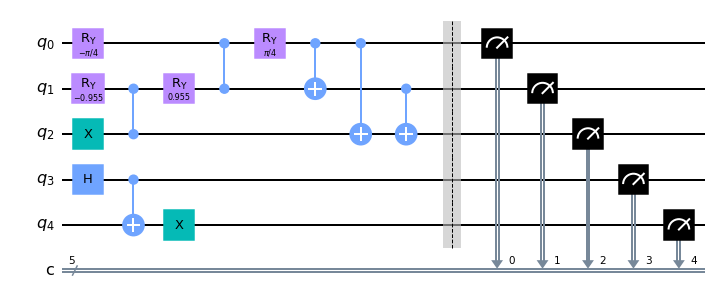

In [23]:
i_state_test = 0
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 0


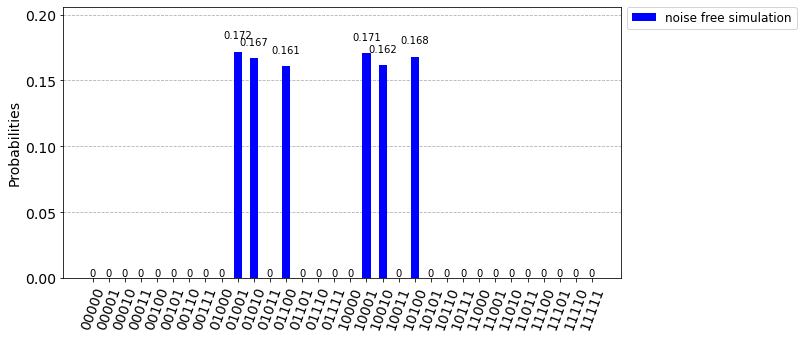

In [24]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

Example of circuit for separable state of the second type for project 2 : $|W\rangle^{\otimes X}\otimes|\Phi^+\rangle$

Ide circuit # 10


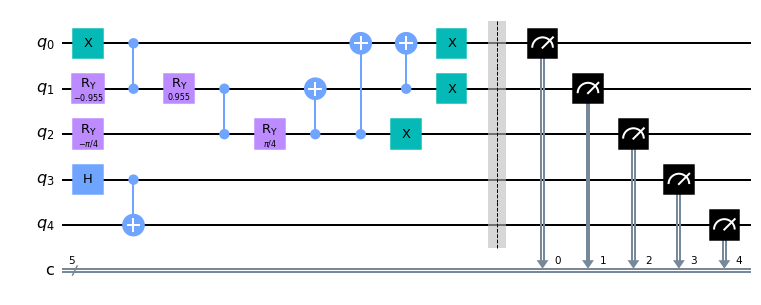

In [25]:
i_state_test = 10
print(device_name, "circuit #",i_state_test)
circ_ideal[i_state_test].draw(output='mpl')

Ide circuit # 10


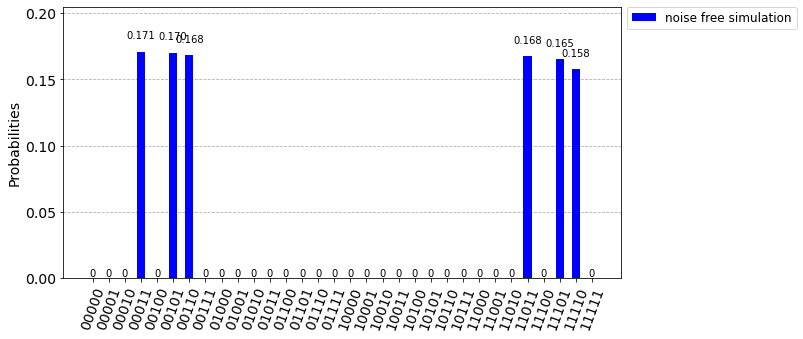

In [26]:
print(device_name, "circuit #",i_state_test)
plot_histogram(ideal_dic[str(i_state_test)],
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [27]:
# try loading the dictionary of results if its creation was skipped
if len(ideal_dic) == 0:
    ideal_dic = json_dic_loader("ideal_dic_"+project_name)

In [28]:
nb_states = len(ideal_dic)
nb_labels = len(list(ideal_dic.values())[0])
s_sim = sum(list(ideal_dic.values())[0].values())

In [29]:
def print_first_and_last_row(PDM):
    print("first and last rows of the probability distribution matrix of dimension "+str(nb_states)+"x"+str(nb_labels))
    print(np.round(PDM[0:1,:],4))
    print("   ...")
    print(np.round(PDM[-1:,:],4))

In [30]:
PD_ideal =  np.ndarray((nb_states,nb_labels))
for i_state in range(nb_states):
    PD_ideal[i_state, :] = list(ideal_dic[str(i_state)].values())
# now a little trick to get the ideal values from the simulator approximated values
with np.errstate(divide='ignore'): # ignore the divide by zero warning
    PD_ideal = 1/np.round(s_sim/(PD_ideal))
# have a look at the matrix head and tail:
print_first_and_last_row(PD_ideal)

first and last rows of the probability distribution matrix of dimension 20x32
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.1667
  0.1667 0.     0.1667 0.     0.     0.     0.     0.1667 0.1667 0.
  0.1667 0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.    ]]
   ...
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.1667 0.     0.     0.1667 0.     0.     0.     0.
  0.1667 0.     0.     0.1667 0.1667 0.     0.     0.1667 0.     0.
  0.     0.    ]]


## Monte Carlo simulation for the ideal device

In [31]:
# here will be appended the data we want for the curve plot 
ideal_data_list=[]

###  you may skip this cell and get stored curves by running the next cell

In [ ]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary (readme file):
trials=100 # to be set to 10000 if not demo 
window=5 # shorter window than for the real device counts
epsilon = .001
min_shots = 5
max_shots = 100
pol=2

subset = None # variable not used here
verbosality = 5 # printing step for intermediate results when increasing the experiment shot number 

PD_test = PD_ideal
mitigation_dic =  {"Na": None} 
o_metrics_desired = ['jensenshannon', 'sqeuclidean']
model_dic = {"ideal_sim": PD_ideal}
for mit_str, mitigation in mitigation_dic.items():
    if mitigation != None: # thus only for counts on real device
        PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    for o_metric in o_metrics_desired:           
            for model_name in model_dic.keys():
                add_single_dic(ideal_data_list)                

markdown for safety
json_dic_dumper(ideal_data_list,"ideal_device_data_list_"+project_name)

In [32]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(ideal_data_list) == 0:
    ideal_data_list = json_dic_loader("ideal_device_data_list_"+project_name)

<Figure size 432x288 with 0 Axes>

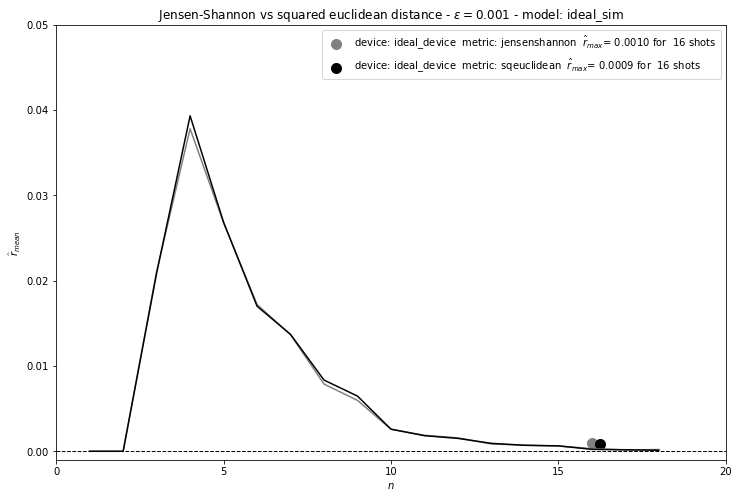

In [33]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors the unsmoothed values 
opl.plot_curves(ideal_data_list,np.array([0,1]),
            "Jensen-Shannon vs squared euclidean distance - $\epsilon=0.001$" , 
             ["model"], ["device","metric"],
             right_xlimit = 20, bottom_ylimit = -0.001, top_ylimit = 0.05)

# Real device section

In [34]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [35]:
project_device = 'ibmq_belem'# you may choice here a different backend
device_name = dev_dic[project_device]
mitig_name = program_name + "_" + device_name
print(mitig_name)

AL2_Bel


In [36]:
#determine here the backend
device = provider.get_backend(project_device) # the backend names are listed here above
properties = device.properties()
coupling_map = device.configuration().coupling_map

# obtain mitigation filter

In [37]:
#markdown for demo
nb_shots_cal = 8192 # set here the number of shots for the calibration phase
print("backend:", device.name(), "qubit_list:", qubit_list)
job_cal = execute(meas_calibs, backend=device, shots=nb_shots_cal)
print(job_cal.job_id())
job_monitor(job_cal)
time_exp = time.strftime('%d/%m/%Y %H:%M:%S')
print("DMY: ",time_exp)

backend: ibmq_belem qubit_list: [0, 1, 2, 3, 4]
6030b642dcdf9277b8ae6261
Job Status: job has successfully run
DMY:  20/02/2021 08:13:24


In [38]:
#markdown for demo
#here we save mitigation results
cal_results = job_cal.result()
cal_results_dic = cal_results.to_dict()
#to make date in dictionary serializable if there is a 'date' key:
if 'date' in cal_results_dic.keys():
    cal_results_dic['date']=str(cal_results_dic['date'])

In [39]:
#markdown for demo and security
#dump
json_dic_dumper(cal_results_dic,"Q_cal_results_dic_"+ mitig_name)

In [40]:
# retrieve the corresponding measurement mitigation filter obtained at experimental time
# use a fake job because use of the from_dict method
simulator = Aer.get_backend('qasm_simulator')
fake_job_cal = execute(meas_calibs, backend=simulator, shots=1)
fake_cal_results = fake_job_cal.result()
cal_results_dic = json_dic_loader("Q_cal_results_dic_"+mitig_name) 
if 'date' in cal_results_dic.keys():
    str(cal_results_dic['date'])
cal_results = fake_cal_results.from_dict(cal_results_dic)
meas_fitter = CompleteMeasFitter(cal_results, label_list, qubit_list=qubit_list, circlabel='mcal')
meas_filter = meas_fitter.filter
# have a look at the average measurement fidefily of this device:
print("Average Measurement Fidelity was: %f" % meas_fitter.readout_fidelity(), "for",project_device)

Average Measurement Fidelity was: 0.842281 for ibmq_belem


### Transpile the basic circuits for running on real device
In this demo, these are not the circuits which were actually run on real devices (not the same transpiler seed).
The optimization level is set to 2 instead of 3 in real experiments, for speed and also because at this moment there is a transpiler error occuring for ibmqx2: 'Maximum iteration reached. max_iteration=1000' 

In [41]:
id_gates = 0
str_nb_id = str(id_gates)
zfilled = str_nb_id.zfill(4-len(str_nb_id))
project_name = mitig_name + "_" + unique_char + zfilled
print(project_name)

AL2_Bel_M000


In [42]:
# transpile
verbose = True  
summary_dic = {}
seed_transpiler_list = list(range(nb_states))
real_circs = []
start_time = time.strftime('%d/%m/%Y %H:%M:%S')    
print("Start at DMY: ",start_time)
for i_state in list(range(nb_states)):    
    # prepare circuit to be transpiled
    circuit = copy.deepcopy(circ_ori[i_state])
    if id_gates > 0:
        circuit.barrier()
        for id_gates_index in range(id_gates):
            for index, value in enumerate(qubit_list):
                circuit.id(value)
    
    new_cut.add_barrier_and_measure(circuit, qubit_list)
    
    summary = []        
    depth_list = [] 

    Q_state_opt_new = transpile(circuit, backend=device,
                        coupling_map = coupling_map,
                        seed_transpiler=seed_transpiler_list[i_state],
                        optimization_level=2,
                        initial_layout=qubit_list)

    summary_dic[i_state] = {"depth": Q_state_opt_new.depth(),
                            'circuit':Q_state_opt_new}
    real_circs.append(Q_state_opt_new)
    if verbose:
        print("circuit %2i" % i_state,"length",summary_dic[i_state]["depth"],
              "DMY: ",time.strftime('%d/%m/%Y %H:%M:%S')) 

end_time = time.strftime('%d/%m/%Y %H:%M:%S')  
print("Completed at DMY: ",end_time)    

Start at DMY:  20/02/2021 08:13:25
circuit  0 length 54 DMY:  20/02/2021 08:13:25
circuit  1 length 67 DMY:  20/02/2021 08:13:25
circuit  2 length 59 DMY:  20/02/2021 08:13:25
circuit  3 length 57 DMY:  20/02/2021 08:13:26
circuit  4 length 69 DMY:  20/02/2021 08:13:26
circuit  5 length 56 DMY:  20/02/2021 08:13:26
circuit  6 length 54 DMY:  20/02/2021 08:13:26
circuit  7 length 60 DMY:  20/02/2021 08:13:26
circuit  8 length 53 DMY:  20/02/2021 08:13:26
circuit  9 length 58 DMY:  20/02/2021 08:13:26
circuit 10 length 58 DMY:  20/02/2021 08:13:26
circuit 11 length 70 DMY:  20/02/2021 08:13:26
circuit 12 length 60 DMY:  20/02/2021 08:13:26
circuit 13 length 55 DMY:  20/02/2021 08:13:27
circuit 14 length 56 DMY:  20/02/2021 08:13:27
circuit 15 length 53 DMY:  20/02/2021 08:13:27
circuit 16 length 59 DMY:  20/02/2021 08:13:27
circuit 17 length 56 DMY:  20/02/2021 08:13:27
circuit 18 length 73 DMY:  20/02/2021 08:13:27
circuit 19 length 72 DMY:  20/02/2021 08:13:27
Completed at DMY:  20/02/

In [43]:
i_state_test = 10
print(project_device, "circuit #",i_state_test,
      "circuit length:",real_circs[i_state_test].depth()) #summary_dic[i_state_test]['depth'])

ibmq_belem circuit # 10 circuit length: 58


# you may want to skip this if large nb of id gates before measurement
real_circs[i_state_test].draw(output='mpl')

ibmq_belem circuit # 10 on noise free simulator


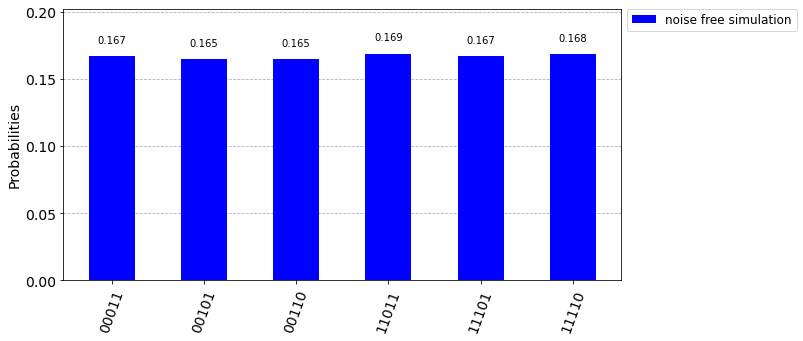

In [44]:
#check a circuit on noise-free simulator
job_simul = execute(real_circs[i_state_test], backend=simulator, shots=s_sim)
print(project_device, "circuit #",i_state_test, "on noise free simulator")
plot_histogram(job_simul.result().get_counts(),
               legend=['noise free simulation'],
               color = "b", figsize=(10.,5.))

# run job

In [45]:
#markdown for demo
#run the circuits
nb_shots = 8192
print("backend:", device.name(), "qubit_list:", qubit_list)
time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
print("DMY: ",time_exp) 
job_real = execute(real_circs, backend=device, optimization_level=0, shots=nb_shots)
job_real_id = job_real.job_id()
print("job id:", job_real_id)
job_monitor(job_real)
time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
print("DMY: ",time_exp, "job id:", job_real_id)
tot_results_real = job_real.result()

empirical_dic ={}
for i_state_count, state_count in enumerate(tot_results_real.get_counts()):
    empirical_dic[str(i_state_count)] = state_count

backend: ibmq_belem qubit_list: [0, 1, 2, 3, 4]
DMY:  20_02_2021_08_13_28
job id: 6030b6a75f4b0b6ef307075e
Job Status: job has successfully run
DMY:  20_02_2021_08_14_44 job id: 6030b6a75f4b0b6ef307075e


In [46]:
#markdown for safety
json_dic_dumper(job_real_id,"job_real_id_"+ project_name)

In [47]:
#markdown for safety at demo
json_dic_dumper(empirical_dic,"experimental_"+ project_name)

In [48]:
#markdown for demo

#2d JOB RUN
nb_shots = 8192
#run the circuits
print("backend:", device.name(), "qubit_list:", qubit_list)
time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
print("DMY: ",time_exp) 
job_test = execute(real_circs, backend=device, optimization_level=0, shots=nb_shots)
job_test_id = job_test.job_id()
print("job id:", job_test_id)
job_monitor(job_test)
time_exp = time.strftime('%d_%m_%Y_%H_%M_%S')
print("DMY: ",time_exp, "job id:", job_test_id)

tot_results_test = job_test.result()

test_dic ={}
for i_state_count, state_count in enumerate(tot_results_test.get_counts()):
    test_dic[str(i_state_count)] = state_count

backend: ibmq_belem qubit_list: [0, 1, 2, 3, 4]
DMY:  20_02_2021_08_14_46
job id: 6030b6f46595d95ba3f206b3
Job Status: job has successfully run
DMY:  20_02_2021_08_17_47 job id: 6030b6f46595d95ba3f206b3


In [49]:
#markdown for safety at demo
json_dic_dumper(job_test_id,"job_test_id_"+ project_name)
json_dic_dumper(test_dic,"test_"+ project_name)

### Load  the transpiled circuits that were actually run 
##### legacy: valid only for the GHZ Psi+ / W Phi- combination
otherwise go instead to:
#### "Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier"


In [52]:
#changing keys of dictionary for merging:    
def key_change(ini_dict, i_subset):
    ini_list = []
    len_ini = len(ini_dict)
    for i in range(len_ini):
        ini_list.append(str(i+i_subset*len_ini))
    return dict(zip(ini_list, list(ini_dict.values()))) 

In [53]:
if program_name == "QAD":
    #retrieve the data corresponding to the 1st project
    lfc = list(Flag_char)
    circ_ideal =[]
    empirical_dic = {}

    for i_subset, subset in enumerate(lfc):
        qasm_circs_dic = json_dic_loader('qasm_circs_dic_QAD_'+device_name+'_'+ subset + zfilled)
        j=0 # j included for project with several transpilation sessions for each device - not used here
        qasm_circs = qasm_circs_dic[str(j)]
        nb_circs = len(qasm_circs)        
        for i_circs in range(nb_circs):
            circ_ideal.append(QuantumCircuit().from_qasm_str(qasm_circs[i_circs]))
        empirical_dic = {**empirical_dic,
                     **key_change(json_dic_loader("experimental"+"_"+mitig_name +"_"\
                                  +subset+zfilled), i_subset)}
    test_dic = copy.deepcopy(empirical_dic)
    #nb_states = len(circ_ideal)

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [54]:
if program_name == "AL2":
    empirical_dic = json_dic_loader('experimental_'+project_name) 
    test_dic = json_dic_loader('test_'+project_name) 

In [55]:
def rectify_counts(tot_res, test_cqi,mitigation,m_filter) :       
        
        void_counts = dict(zip(label_list, np.zeros(2**used_qubits)))
        try:
            counts_results_real_test = tot_res[str(test_cqi)]
        except KeyError as error:            
            counts_results_real_test = tot_res[test_cqi]

        raw_counts_test = copy.deepcopy(void_counts)
        raw_counts_test.update(counts_results_real_test)

        if mitigation:
            mitigated_results_test = meas_filter.apply(raw_counts_test, method = 'least_squares')
            returned_counts = copy.deepcopy(void_counts)
            returned_counts.update(mitigated_results_test)
                        
        else:
            returned_counts = copy.deepcopy(raw_counts_test)
            
        return returned_counts

### Obtain the matrix of probability distribution of shape(nb_state,nb_labels) used by the classifier

In [56]:
def get_clean_matrix(dic, mitigation,m_filter):
    clean_matrix =  np.ndarray((nb_states,nb_labels)) 
    for i_state in range(nb_states):
        rectified_counts = rectify_counts(dic,i_state, mitigation,m_filter) # get a rectified counts dictionary       
        clean_matrix[i_state, :] = list(rectified_counts.values())
    clean_matrix = clean_matrix/clean_matrix.sum(axis=1, keepdims=True)
    return clean_matrix  

In [57]:
# We need to create a first matrix version. It will then vary for each considered set of distribution
mitigation = False
PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter) 
print_first_and_last_row(PD_exper)

first and last rows of the probability distribution matrix of dimension 20x32
[[4.500e-03 1.860e-02 1.540e-02 1.000e-03 1.930e-02 2.200e-03 1.300e-03
  1.100e-03 2.930e-02 1.370e-01 1.344e-01 5.700e-03 1.383e-01 1.040e-02
  1.100e-02 8.400e-03 2.980e-02 1.373e-01 1.272e-01 3.800e-03 1.245e-01
  1.140e-02 1.070e-02 8.100e-03 9.000e-04 2.400e-03 2.300e-03 4.000e-04
  2.600e-03 1.000e-04 6.000e-04 1.000e-04]]
   ...
[[0.0166 0.0024 0.004  0.0114 0.0148 0.0031 0.0049 0.0123 0.0298 0.0055
  0.007  0.0199 0.1431 0.0238 0.037  0.1409 0.0216 0.0052 0.005  0.0149
  0.0929 0.0145 0.0215 0.0712 0.1252 0.0201 0.0243 0.0729 0.0148 0.0032
  0.0055 0.0109]]


In [58]:
if program_name == "QAD":
    PD_test = copy.deepcopy(PD_exper)
elif program_name == "AL2":
    mitigation = False
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                                m_filter=meas_filter) 
    print_first_and_last_row(PD_test)

first and last rows of the probability distribution matrix of dimension 20x32
[[3.700e-03 1.820e-02 1.700e-02 1.100e-03 1.870e-02 1.200e-03 1.200e-03
  1.700e-03 3.190e-02 1.353e-01 1.350e-01 5.400e-03 1.333e-01 1.140e-02
  1.110e-02 8.400e-03 3.210e-02 1.367e-01 1.293e-01 6.600e-03 1.237e-01
  9.900e-03 1.090e-02 6.300e-03 5.000e-04 2.700e-03 2.300e-03 1.000e-04
  3.400e-03 5.000e-04 5.000e-04 1.000e-04]]
   ...
[[0.02   0.0032 0.0066 0.0138 0.0151 0.0024 0.005  0.0146 0.0255 0.0038
  0.0096 0.02   0.149  0.0215 0.0483 0.1361 0.0215 0.0039 0.0066 0.0159
  0.0895 0.0114 0.0231 0.0708 0.1211 0.0181 0.0275 0.0669 0.0142 0.0023
  0.0039 0.0088]]


## Monte Carlo simulation for the real device

In [64]:
# here will be appended the data we want for the final plot of this notebook
empirical_data_list=[]

###  you may want to skip this cell and get stored curves by running the next cell

In [65]:
# you may want to skip this cell as it will require a long time
# because of the high number of trials required by the Monte Carlo simulation for each nb o shots value

# the following values are defined in the study summary notebook:
trials=10000 # should be 1000 if not demo
window=11
epsilon = .001
max_shots = 500
pol=2

verbosality = 10 # printing step for intermediate results when increasing the experiment shot number 

# In this section you can easily make your choice of combinations:
# mitigation or not, metric, model 

mitigation_dic =  {"no":False, "yes" : True} 
#mitigation_dic =  {"no":False} 
#mitigation_dic =  {"yes" : True} 

o_metrics_desired = ['jensenshannon', 'sqeuclidean']
#o_metrics_desired = ['jensenshannon']
#o_metrics_desired = ['sqeuclidean']

model_dic = {"empirical": PD_exper, "ideal_sim": PD_ideal}
#model_dic = {"empirical": PD_exper}
#model_dic = {"ideal_sim": PD_ideal}

# Obtain a sequence of results in form of a list of dictionaries

for mit_str, mitigation in mitigation_dic.items():
    # here we toggle PD_exper as we toggled mitigation status
    PD_exper = get_clean_matrix(empirical_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    PD_test = get_clean_matrix(test_dic, mitigation=mitigation,
                            m_filter=meas_filter)
    for o_metric in o_metrics_desired:
        print(project_name, model_dic.keys(), o_metric)        
        for model_name in model_dic.keys():
            add_single_dic(empirical_data_list)

AL2_Bel_M000 dict_keys(['empirical', 'ideal_sim']) jensenshannon
started 20/02/2021 08:32:15 AL2_Bel mitigation no jensenshannon empirical
10 0.094565 [ 824  791 1122  977  973 1054 1437 1267  863  954  334 1098  990  329
  764  755 1134  790 1509  948]
20 0.008025 [ 85  53 111  74  78  75 205  97  50  53  21  91  62  13  52  65 100  56
 163 101]
30 0.0007599999999999999 [ 9  4 10  7  7  4 35  6  2  7  0  7  9  0  4  7  7  5 16  6]
40 0.00014 [ 0  1  2  0  1  0 16  2  0  0  0  0  1  1  0  1  1  1  1  0]
safe_shot_nb 41 safe_rate 0.0008941724941724969 nb trials: 10000
savgol interpolated error rate mean: 0.0001 min: -0.0 max: 0.0009 for [6]
completed 20/02/2021 09:03:30 AL2_Bel mitigation no jensenshannon empirical 

started 20/02/2021 09:03:30 AL2_Bel mitigation no jensenshannon ideal_sim
10 0.058820000000000004 [302 313 813 430 740 595 666 657 633 665 249 894 595 208 511 327 969 553
 967 677]
20 0.008525 [ 17  22 146  30 131  82  63  92  90  92  11 192  90  15  54  22 187  58
 193 118

In [66]:
#markdown fo security
json_dic_dumper(empirical_data_list,'Tnemp_data_list_'+project_name)

In [67]:
# get the stored results of the Monte Carlo simulation in case you skipped the previous step
if len(empirical_data_list) == 0:
    empirical_data_list  = json_dic_loader('Tnemp_data_list_'+project_name) 

<Figure size 432x288 with 0 Axes>

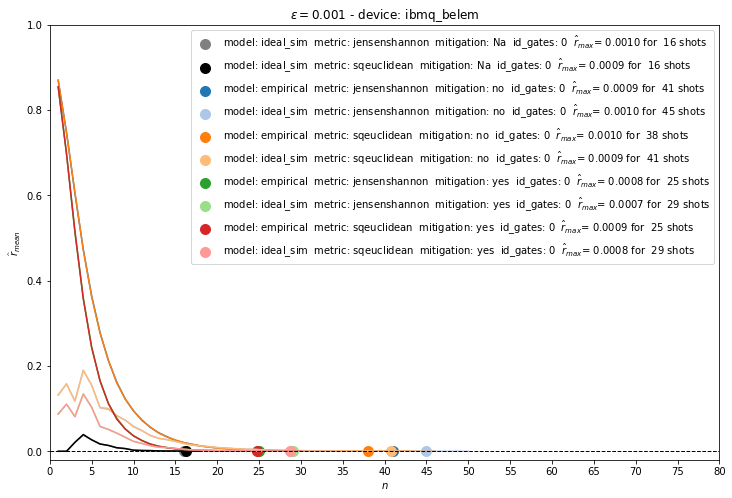

In [68]:
# have a look at the mean error rate curves and error rate at save shot number n_s
# NB the r_hat_mean curves and legend reported r_hat_max errors are the unsmoothed values 
opl.plot_curves(ideal_data_list + empirical_data_list,
                np.array(range(2+len(empirical_data_list))),
            "$\epsilon=0.001$" , ["device"],
            ["model","metric","mitigation","id_gates"],
            right_xlimit = 80, bottom_ylimit = -0.02, top_ylimit = 1)

In [ ]:
import winsound
duration = 2000  # milliseconds 
freq = 800  # Hz
winsound.Beep(freq, duration)

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table